# Libraries

In [152]:
# if you use google colab, install the following libraries:
# !pip install emoji datasets contractions pyLDAvis fasttext -U ipykernel

In [1]:
import os
import re
import pickle
import string
from pprint import pprint
from math import sqrt, pow, exp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import emoji
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext
from sklearn.manifold import TSNE

plt.style.use('seaborn-v0_8-pastel')

## Amazon US reviews

Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. 

Each Dataset contains the following columns: 
- marketplace - 2 letter country code of the marketplace where the review was written. 
- customer_id - Random identifier that can be used to aggregate reviews written by a single author. 
- review_id - The unique ID of the review. 
- product_id - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id. 
- product_parent - Random identifier that can be used to aggregate reviews for the same product. 
- product_title - Title of the product. 
- product_category - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). 
- star_rating - The 1-5 star rating of the review. 
- helpful_votes - Number of helpful votes. total_votes - Number of total votes the review received. 
- vine - Review was written as part of the Vine program. 
- verified_purchase - The review is on a verified purchase. 
- review_headline - The title of the review. 
- review_body - The review text. 
- review_date - The date the review was written.

Visit this [site](https://huggingface.co/datasets/amazon_us_reviews) for more information.

# Introduction

We're going to build a exploratory data analysis (EDA) notebook. We'll explore different kind of aspects from the following questions:
- How big is this data set?
- What fields can we find here and what they mean?
- Does this data set contain duplicated data?
- What is the data distribution by field?
- Do these fields contain nulls? How can we treat them?
- Are these fields correlated? What decisions can we make based on this?

We might answer some or all of these questions, however we'll put more enphasis on text data. For text data, we can formulate the following questions:
- How big is it? How many documents and words do we have? What is the vocabulary size?
- How long are the documents?
- Are there any missings or empty texts?
- Are there any special character in the data or emoticons?
- Are there any spelling mistakes in the data?
- What are some common words or phrases in general or by any specific category or label?
- Are there any pre-defined categories or topics associated with the text data?
- Are there any trends or patterns over time?

We're also going to explore different kind of text representations and how they're visualized.

Finally, we're going to explore some topics found on the data.

# Load data set

In [2]:
english_dataset = load_dataset('amazon_us_reviews', 'Video_Games_v1_00')

Found cached dataset amazon_us_reviews (/home/rodrigo/.cache/huggingface/datasets/amazon_us_reviews/Video_Games_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# for this exercise we're going to select just a sample of the data
sample_size = 5_000
df = english_dataset['train'].to_pandas().sample(sample_size, random_state=18)
print(f"Sample size: {round(sample_size/english_dataset['train'].num_rows*100,2)}%")

Sample size: 0.28%


In [4]:
# save data for further analysis
df.to_parquet('../data/df_amazon_reviews_sample_5k.gzip', compression='gzip')

In [2]:
# load data
df = pd.read_parquet('../data/df_amazon_reviews_sample_5k.gzip')

# Exploratory data analysis

In [5]:
print(f'Number of documents in the dataset: {df.shape[0]}')
print(f'Number of fields in the dataset: {df.shape[1]}')

Number of documents in the dataset: 5000
Number of fields in the dataset: 15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1660627 to 991948
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        5000 non-null   object
 1   customer_id        5000 non-null   object
 2   review_id          5000 non-null   object
 3   product_id         5000 non-null   object
 4   product_parent     5000 non-null   object
 5   product_title      5000 non-null   object
 6   product_category   5000 non-null   object
 7   star_rating        5000 non-null   int32 
 8   helpful_votes      5000 non-null   int32 
 9   total_votes        5000 non-null   int32 
 10  vine               5000 non-null   int64 
 11  verified_purchase  5000 non-null   int64 
 12  review_headline    5000 non-null   object
 13  review_body        5000 non-null   object
 14  review_date        5000 non-null   object
dtypes: int32(3), int64(2), object(10)
memory usage: 566.4+ KB


We notice from the feature report that some variables are binary like 'vine' and 'verified_purchase'.
No nulls detected in dataset

# Field analysis

In [8]:
# check empty review bodies
(df.review_body.str.len() == 0).value_counts()

review_body
False    5000
Name: count, dtype: int64

In [9]:
# check unique values
for field in df.columns:
    print(f"There are(is) {df[field].nunique():,} unique value(s) for {field}")

There are(is) 1 unique value(s) for marketplace
There are(is) 4,957 unique value(s) for customer_id
There are(is) 5,000 unique value(s) for review_id
There are(is) 3,591 unique value(s) for product_id
There are(is) 3,528 unique value(s) for product_parent
There are(is) 3,115 unique value(s) for product_title
There are(is) 1 unique value(s) for product_category
There are(is) 5 unique value(s) for star_rating
There are(is) 63 unique value(s) for helpful_votes
There are(is) 86 unique value(s) for total_votes
There are(is) 2 unique value(s) for vine
There are(is) 2 unique value(s) for verified_purchase
There are(is) 3,927 unique value(s) for review_headline
There are(is) 4,896 unique value(s) for review_body
There are(is) 2,451 unique value(s) for review_date


In [10]:
# check features with few unique values
print(f"Unique values in market place are: {df['marketplace'].unique()}")
print(f"Unique values in product category are: {df['product_category'].unique()}")
print(f"Unique values in star rating are: {sorted(df['star_rating'].unique())}")
print(f"Unique values in vine are: {sorted(df['vine'].unique())}")
print(f"Unique values in verified purchase are: {sorted(df['verified_purchase'].unique())}")

Unique values in market place are: ['US']
Unique values in product category are: ['Video Games']
Unique values in star rating are: [1, 2, 3, 4, 5]
Unique values in vine are: [0, 1]
Unique values in verified purchase are: [0, 1]


We'll remove market place and product category when creating the ML feature data set. This situation is obvious since we have selected US amazon reviews and just for the video game product category. Vine and verified_purchase are expected to be binary because of the variable definition

## Analyze customers

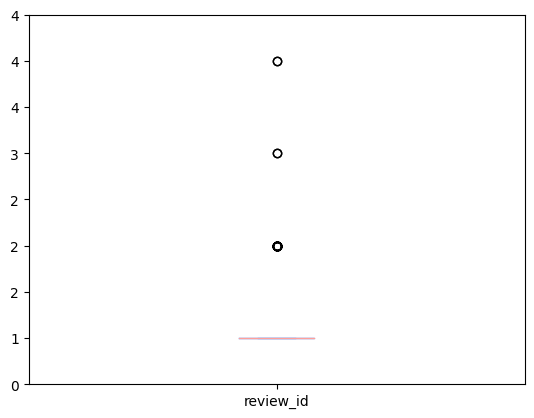

In [11]:
# reviews by customer
df.groupby('customer_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [12]:
df.groupby('customer_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    4,957.000
mean         1.009
std          0.109
min          1.000
25%          1.000
50%          1.000
75%          1.000
90%          1.000
95%          1.000
99%          1.000
max          4.000
Name: review_id, dtype: object

Up 99% of customers made up to 1 review in this sample

In [13]:
# sample of reviews done by the customer with highest number of reviews
customers = df.groupby('customer_id')['review_id'].count()
outlier = customers[customers == 4].index[0]
df[df.customer_id == outlier].sample(3, random_state=18)[['review_id','customer_id','review_headline','review_body','review_date']]

,review_id,customer_id,review_headline,review_body,review_date
1134160,R10IZVZV1GK75D,40955995,A very unique puzzle game,"The Good: Innovative gameplay, great graphics ...",2012-03-29
1133982,R3H90SO0ON6P2N,40955995,A very dark and sadistic game,"The Good: Creepy unsettling atmosphere, grueso...",2012-03-29
1134601,R1U54UKO36ERYU,40955995,The lack of a simulation mode makes the game b...,"The Good: Superb visuals, lots of tracks and c...",2012-03-28


## Analyze products

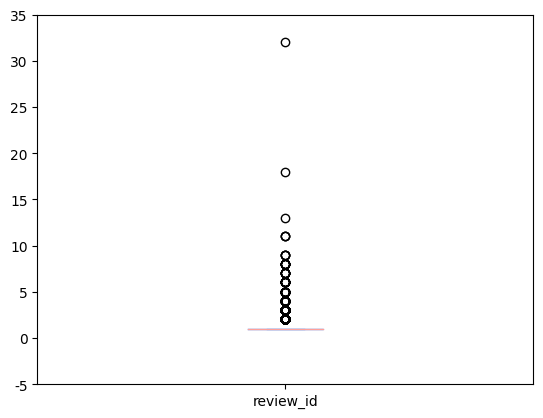

In [14]:
# check amount of reviews by product
df.groupby('product_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [15]:
df.groupby('product_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    3,591.000
mean         1.392
std          1.147
min          1.000
25%          1.000
50%          1.000
75%          1.000
90%          2.000
95%          3.000
99%          6.000
max         32.000
Name: review_id, dtype: object

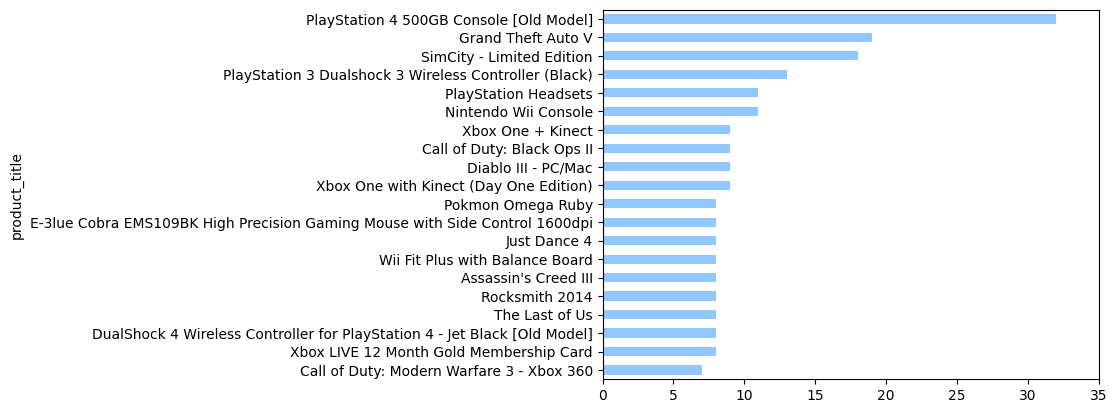

In [16]:
# sample of reviews done by the customer with highest number of reviews
products = df.groupby('product_id')['review_id'].count()
outliers = products[products >= 6].index.values
df[df.product_id.isin(outliers)].product_title.value_counts().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f'{x:,.0f}' for x in plt.gca().get_xticks()]);

Most of the reviews have been done to the PS4 then GTA V and so on. That shows the popularity of those game products.

## Analyze star rating

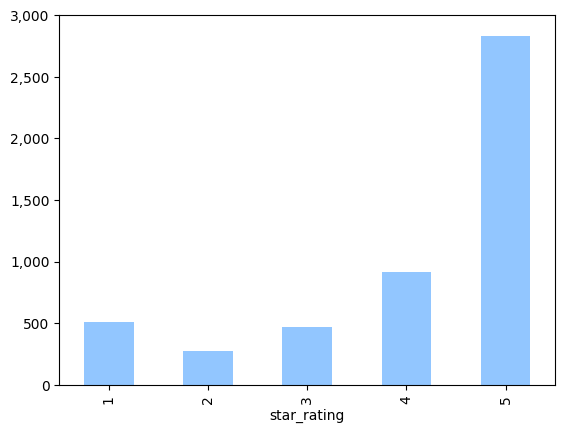

In [17]:
# check number of reviews for star rating
df.groupby('star_rating')['review_id'].count().plot(kind='bar')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

There's a clear evidence that there's a big number of videogames that are great games. If we'd like to classify texts using this field as label, we'd need to be careful with unbalance.

## Analyze verified purchase

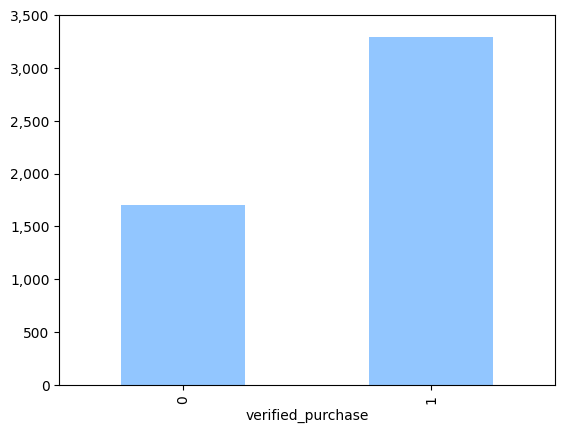

In [18]:
# check reviews by verified purchase

df.groupby('verified_purchase')['review_id'].count().plot(kind='bar')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(f'{x:,.0f}' for x in plt.gca().get_yticks());

We can see that almost 50% of the reviews in this sample come from not verified purchases.

## Analyze helpfull votes

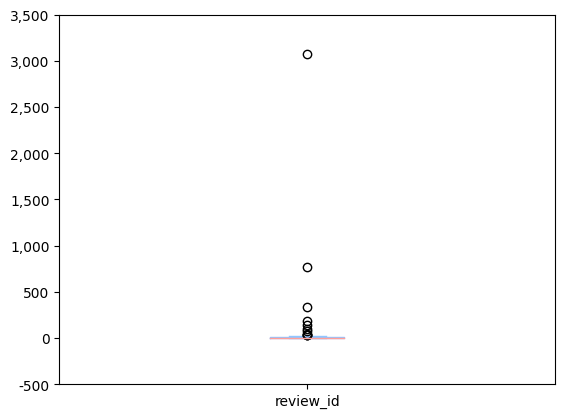

In [5]:
# check amount of reviews by helpful votes

df.groupby('helpful_votes')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [6]:
df.groupby('helpful_votes')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count       63.000
mean        79.365
std        397.480
min          1.000
25%          1.000
50%          3.000
75%          9.500
90%         68.400
95%        182.400
99%      1,642.620
max      3,068.000
Name: review_id, dtype: object

Up to 75 % of the votes have up to ~9 reviews. There are some vote quantities that are outliers based on these reports

In [7]:
# show what vote amounts have the highest amount of reviews
votes = df.groupby('helpful_votes')['review_id'].count()
votes[votes > 60]

helpful_votes
0    3068
1     769
2     335
3     187
4     141
5      94
6      74
Name: review_id, dtype: int64

## Analyze reviews through time

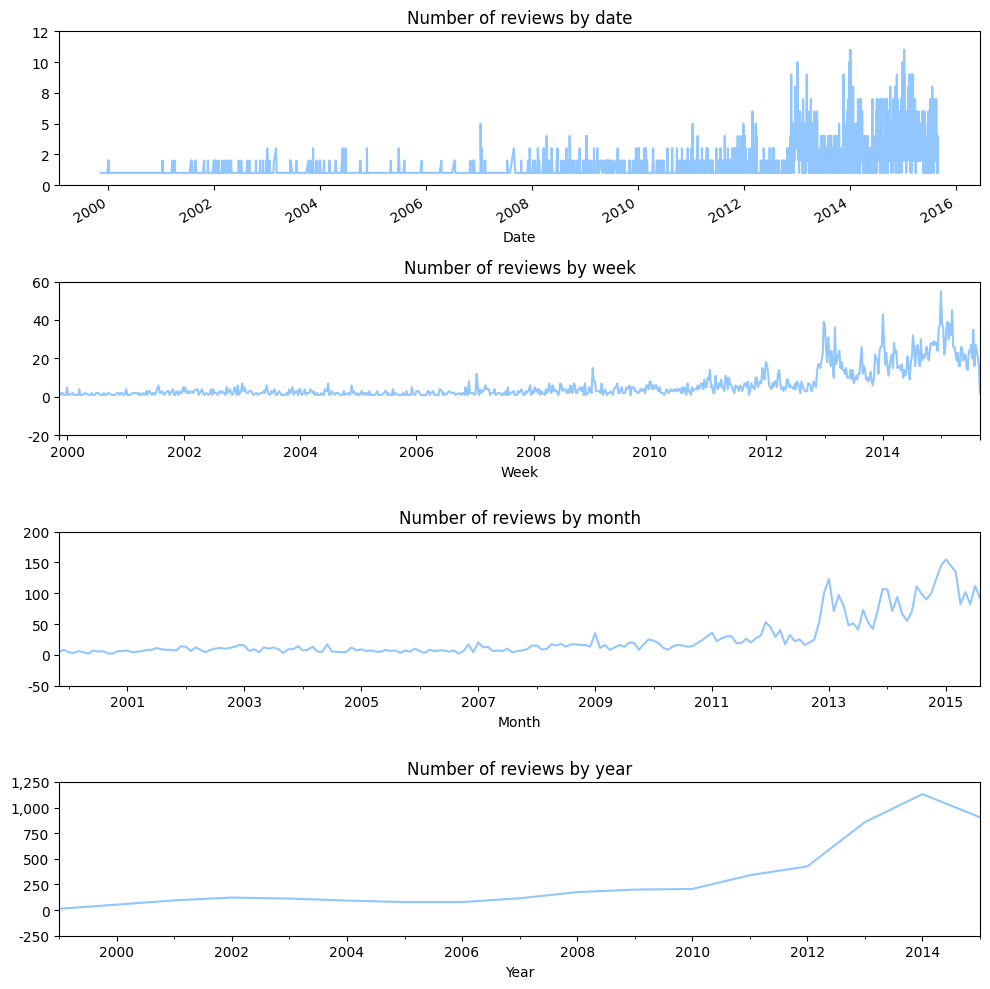

In [21]:
# check amount of reviews by date dimension
df['review_date'] = df.review_date.astype('datetime64[ns]')
df['review_week'] = df.review_date.dt.to_period('W')
df['review_month'] = df.review_date.dt.to_period('M')
df['review_year'] = df.review_date.dt.to_period('Y')

fig, axs = plt.subplots(4,1)
date_columns = ['review_date', 'review_week', 'review_month', 'review_year']
for i, column in enumerate(date_columns):
    df.groupby(column)['review_id'].count().plot(kind='line',figsize=(10,10), ax=axs[i])
    axs[i].set_xlabel(f"{(column.split('_')[1]).capitalize()}")
    axs[i].set_yticks(axs[i].get_yticks())
    axs[i].set_yticklabels(f'{x:,.0f}' for x in axs[i].get_yticks())
    axs[i].set_title(f"Number of reviews by {column.split('_')[1]}")
plt.tight_layout();

We can see a positive trend when analyzing the data by year. Also, there's evidence of seasonality specially since 2013 when analyzing the data monthly. That happens because of the high amount of reviews by the end/start of the year and a lower peak in the middle of the year, both repeat in a positive trend yearly.

## Explore text fields

### Word size distribution

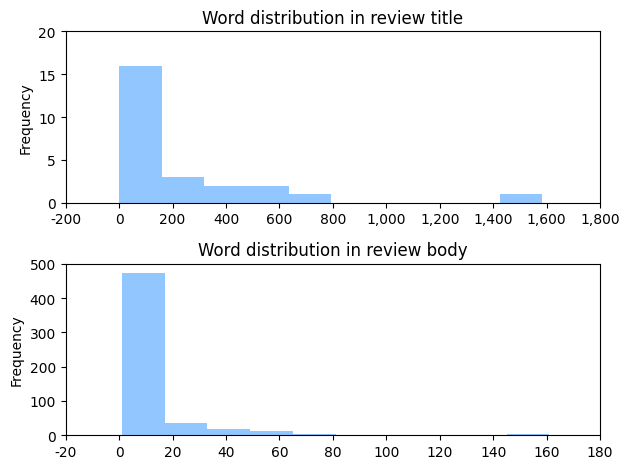

In [22]:
# get the word size per document and show the distribution

fig, axs = plt.subplots(2,1)

df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[0])
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[1])

axs[0].set_title('Word distribution in review title')
axs[1].set_title('Word distribution in review body')

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(f'{x:,.0f}' for x in ax.get_xticks())
fig.tight_layout();

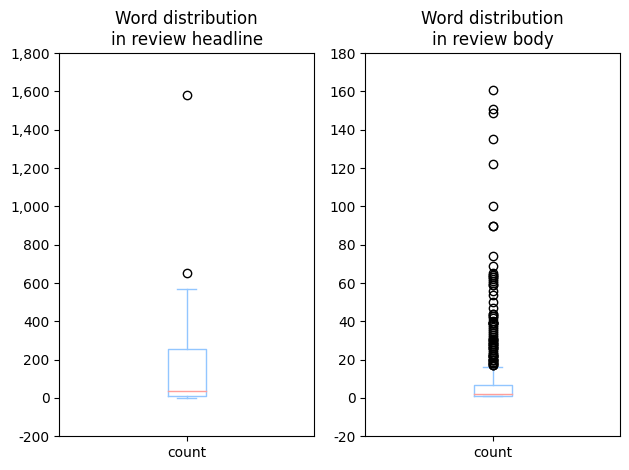

In [23]:
# show also the box plot
fig, axs = plt.subplots(1,2)

df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[0])
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[1])

axs[0].set_title('Word distribution\nin review headline')
axs[1].set_title('Word distribution\nin review body')

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
plt.tight_layout()

In [24]:
pd.DataFrame({'word_stats_headline': df['review_headline'].apply(lambda x: len(x.split())).describe(),
            'word_stats_body': df['review_body'].apply(lambda x: len(x.split())).describe()
            }).style.format('{:,.2f}')

,word_stats_headline,word_stats_body
count,"5,000.00","5,000.00"
mean,4.26,100.28
std,3.25,200.89
min,1.00,1.00
25%,2.00,21.00
50%,3.00,39.00
75%,6.00,97.00
max,29.00,"3,062.00"


Focusing on the review bodies, in average there are ~100 words per review, median is 39 words per review, and the maximum is 3k words.

### Emoticon analysis

In [25]:
# example of how use 'emoji' library
text_example = 'my opinion: 😄 Positive on this..., but 😭 Negative on this ... 👍'

# list emojis in text
emoji.emoji_list(text_example)

[{'match_start': 12, 'match_end': 13, 'emoji': '😄'},
 {'match_start': 39, 'match_end': 40, 'emoji': '😭'},
 {'match_start': 62, 'match_end': 63, 'emoji': '👍'}]

In [26]:
# 'demojize' text
print(emoji.demojize(text_example))

my opinion: :grinning_face_with_smiling_eyes: Positive on this..., but :loudly_crying_face: Negative on this ... :thumbs_up:


  0%|          | 0/5000 [00:00<?, ?it/s]

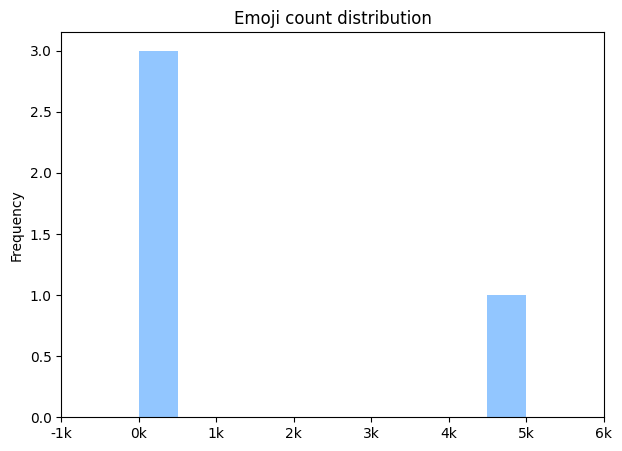

In [9]:
# count the amount of emojis in each document and plot distribution

emojis = df.review_body.progress_apply(lambda x: len(emoji.emoji_list(x)))
emojis.value_counts().plot(kind='hist', figsize=(7,5))
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f'{round(x/1000,2):,.0f}k' for x in plt.gca().get_xticks()])
plt.title('Emoji count distribution');

In [10]:
# emoji stats
emojis.value_counts().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f'{x:,.2f}')

count        4.00
mean     1,250.00
std      2,494.00
min          1.00
25%          1.00
50%          4.00
75%      1,253.00
90%      3,495.80
95%      4,243.40
99%      4,841.48
max      4,991.00
Name: count, dtype: object

In [18]:
# show what emoji amounts have the highest review quantity
emojis.value_counts()

review_body
0    4991
1       7
2       1
7       1
Name: count, dtype: int64

In [20]:
# check the top reviews with the highest emoji counts
with pd.option_context('display.max_colwidth', None):
    display(df[df.index.isin(emojis.sort_values(ascending=False).head(1).index)][['review_id','product_title','star_rating','review_headline','review_body','review_date']])

,review_id,product_title,star_rating,review_headline,review_body,review_date
180063,R16UMWJYWWJCE6,Rayman Origins,5,Five Stars,I purchased this game for my baby 👶 boy and he plays it all day 👍👍👍👍👍👍,2015-03-28


### Special character analysis

In [30]:
# count special characters being used by document. Common special characters are not being considered as "special"

special_characters = df.review_body.progress_apply(lambda x: re.sub(r"[a-zA-Z0-9 ,.\-:\?\!()']",'',x))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [31]:
# show some special characters found
special_characters_exploded = special_characters.apply(lambda x: np.unique([w.strip() for w in x])).explode()
special_characters_exploded[~special_characters_exploded.isnull()].unique()[:100]

array(['"', '/', '<', '>', '\\', '&', '%', ';', '~', '$', '@', '+', '#',
       '*', 'Ñ', '[', ']', '=', '_', '\x1a', '\ufeff', '®', '`', '…', '👏',
       'à', 'é', 'ñ', '—', '’', '´', '（', '“', '”', '！', 'á', '☺', '😉',
       '{', '}', '^', 'í', 'ú', '¡', '😄', '😡', '½', 'ó', '😕', '👍', '👶'],
      dtype=object)

### Word cloud 

/home/rodrigo/anaconda3/envs/py3108/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


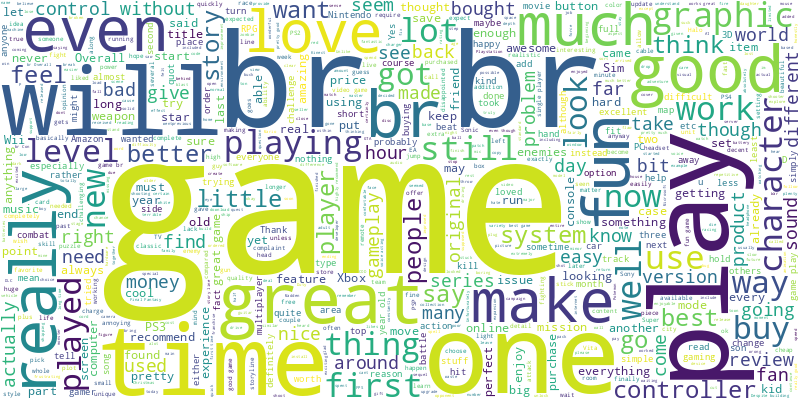

In [32]:
# Join the different processed titles together.
long_string = ','.join(df['review_body'].values)

# Create the WordCloud
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

From the wordcloud, we can see expected words to appear like game, play, etc. What is not expected is finding words like br. This is a candidate to be a stop word.